# Sparse matrices and iterative methods

## Sparse format

Large matrices whose entries are mostly zeros are typically called *sparse*. They can be stored more efficiently than "dense" or full matrices, but must explicitly be constructed as a sparse type. 

In [1]:
using LinearAlgebra, SparseArrays
A = sprandn(10000,10000,0.0004);
varinfo(Main,r"A")

| name |        size | summary                                    |
|:---- | -----------:|:------------------------------------------ |
| A    | 703.195 KiB | 10000×10000 SparseMatrixCSC{Float64,Int64} |


The equivalent full (or "dense") matrix requires almost 800 MB of storage. 

In [2]:
Afull = Matrix(A);
varinfo(Main,r"Afull")

| name  |        size | summary                      |
|:----- | -----------:|:---------------------------- |
| Afull | 762.939 MiB | 10000×10000 Array{Float64,2} |


Two common ways to inspect a sparse matrix are `nnz`, the number of nonzeros, and `spy`, which shows the locations of the nonzeros.

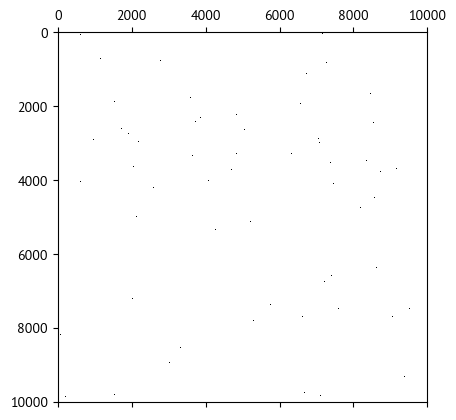

39994

In [3]:
using PyPlot
spy(Afull)
nnz(A)

You can use `findnz` to get all the nonzero elements and their locations.

In [4]:
i,j,s = findnz(A)

([1082, 2624, 2690, 3318, 3722, 9741, 1233, 2878, 4551, 6767  …  9943, 1381, 2195, 3205, 3453, 3516, 4004, 6026, 7223, 7693], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2  …  9998, 9999, 9999, 9999, 9999, 9999, 10000, 10000, 10000, 10000], [-0.790453, 0.289505, 3.30774, -0.906384, 0.968966, 0.349049, -0.273863, -0.319099, -0.752398, 0.294142  …  1.26307, 0.991248, 1.08676, -0.131784, 0.353355, 1.13204, 0.141726, -0.171729, 0.352718, -0.649349])

In [5]:
(s[1],A[i[1],j[1]])

(-0.7904525567382062, -0.7904525567382062)

## Making sparse matrices

If the matrix is not too big, you can construct it as usual and then use `sparse` to convert it. This is rarely the best option for real work, though. 

You can also use the `sparse` function to construct a sparse matrix, essentially as the inverse operation of `findnz` above.

In [ ]:
AA = sparse(i,j,s,10000,10000)

Sometimes it's handy to construct a sparse matrix by its values along diagonals, using `spdiagm`.

In [6]:
B = spdiagm( 0=>1:6, 2=>1:4, -1=>10:10:50 )

6×6 SparseMatrixCSC{Int64,Int64} with 15 stored entries:
  [1, 1]  =  1
  [2, 1]  =  10
  [2, 2]  =  2
  [3, 2]  =  20
  [1, 3]  =  1
  [3, 3]  =  3
  [4, 3]  =  30
  [2, 4]  =  2
  [4, 4]  =  4
  [5, 4]  =  40
  [3, 5]  =  3
  [5, 5]  =  5
  [6, 5]  =  50
  [4, 6]  =  4
  [6, 6]  =  6

In [7]:
Matrix(B)

6×6 Array{Int64,2}:
  1   0   1   0   0  0
 10   2   0   2   0  0
  0  20   3   0   3  0
  0   0  30   4   0  4
  0   0   0  40   5  0
  0   0   0   0  50  6

## Sparse operations

Sparse matrices are not just more memory-efficient. They are able to ignore structural zeros when taking sums and products.

In [8]:
v = rand(10000);

@time for k = 1:100 
    A*v; 
end

  0.051912 seconds (94.68 k allocations: 12.461 MiB)


In [9]:
@time for k = 1:100
    Afull*v; 
end

  4.739046 seconds (345.72 k allocations: 24.378 MiB, 0.17% gc time)


One thing to watch out for, though: the way a sparse matrix is stored can make column operations a *lot* faster than row operations, so plan accordingly. 

In [10]:
B = copy(A);
@time B[1000,:] = sum(B,dims=1); 
B = copy(A);
@time B[:,1000] = sum(B,dims=2); 

  0.390580 seconds (932.78 k allocations: 46.911 MiB, 8.48% gc time)
  0.109197 seconds (284.24 k allocations: 15.628 MiB)


## Sparse backslash

There are algorithms that attempt to exploit sparsity when solving linear systems of equations. They will be called automatically when backslash is used on a sparse matrix. The time required varies wildly, but these methods can be surprisingly effective, especially for well-known common problems such as the 5-point Laplacian approximation. 

In [11]:
n = 500; @show m = (n-1)^2
J = spdiagm(0=>ones(n-1)); D = spdiagm(0=>fill(-2.,n-1),1=>ones(n-2),-1=>ones(n-2))/n^2
L = kron(J,D) + kron(D,J);
b = ones(m);
@time x = L\b; 

m = (n - 1) ^ 2 = 249001
  4.539513 seconds (5.14 M allocations: 672.601 MiB, 4.37% gc time)


As you can see, a 250,000 by 250,000 matrix might not be considered 'large' in every sense!

## Matrix fill-in

Not all is easy in sparse-land, though. The problem is that most operations on sparse matrices leave them less sparse, a phenomenon called *fill-in*.

Take matrix powers, for example.

In [12]:
A = sprandn(10000,10000,.0005)
@show nnz(A);
@show nnz(A*A);
@show nnz(A*A*A);

nnz(A) = 50092
nnz(A * A) = 250865
nnz(A * A * A) = 1245920


Algorithmically speaking, when we write $A^3x$, we think of it as $A(A(Ax))$, which is much faster in the general sparse case. 

Fill-in is especially damaging when attempting LU factorization. Bandedness can be preserved if pivoting is not used, but that invites instability.

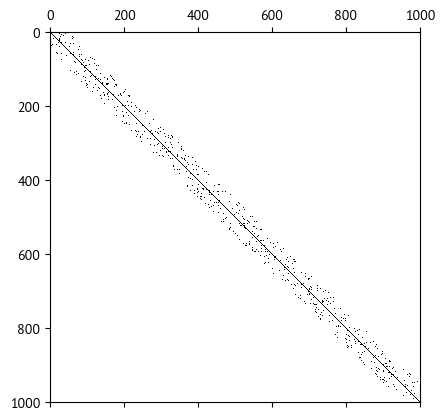

PyObject <matplotlib.image.AxesImage object at 0x15096d128>

In [13]:
A = triu(tril(sprandn(1000,1000,0.05),50),-50) + 0.02I;
using PyPlot
spy(Matrix(A))

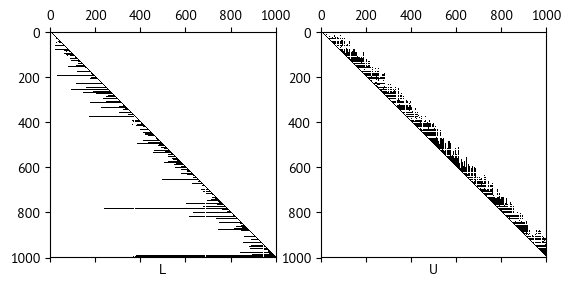

(PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x15099cac8>, PyObject <matplotlib.image.AxesImage object at 0x167b99358>, PyObject Text(0.5,23,'U'))

In [14]:
L,U = lu(Matrix(A))
subplot(121), spy(L), xlabel("L")
subplot(122), spy(U), xlabel("U")

There are clever heuristics for minimizing the fill-in, but they are far from foolproof. 